# Partial Differential Equations 1 - Relaxation Methods

In this notebook, we will illustrate the use of relaxation for solving time-independent boundary value problems, using electrostatics as an example. Relaxation is an iterative technique for solving linear systems of equations, in which an initial guess at a solution is supplied, and allowed to "relax" via iteration towards the final solution.

Here we study three different methods :
* Jacobi
* Gauss-Seidel
* Successive Over Relaxation (SOR)

In addition, we will make use of a "class" to simplify the code.

# 1. The Laplace Equation

Consider the Laplace equation $(\nabla^2V = 0)$ in one dimension. The grid of nodes in this case can be taken as a series of $n$ equally spaced points $x_i$ with a spacing $\Delta x = h$. The Taylor expansion of $V$ around the point $x_i$ is :

$$ V(x) = V(x_i) + h \frac{dV(x_i)}{dx} + h^2 \frac{d^2V(x_i)}{2 dx^2} + ...$$

so adding the values at $\Delta x = \pm h$ (i.e. at $x_{n \pm 1}$) gives :

$$ V(x_{i−1}) + V(x_{i+1}) = 2V(x_i) + h^2 \frac{d^2V(x_i)}{dx^2} $$

which can be rearranged to give Equation 1 :

$$ \frac{d^2V(x_i)}{dx^2} = \frac{V(x_{i−1}) + V(x_{i+1}) − 2V(x_i)}{h^2}  $$

This is the standard finite difference representation for the second derivative.

Generalising this equation to 2D, and rearranging, gives Equation 2, that can be used to iterate the value at each node:

$$ V(x_i,y_j)= \frac{1}{4} (V(x_{i−1},y_j)+V(x_{i+1},y_j)+V(x_i,y_{j−1})+V(x_i,y_{j+1}))$$

Hence each node is simply the average of its four closest neighbours.

# 2. Jacobi Method

First we consider the Jacobi method. Here we store two copies of the grid, and for each iteration we compute a new value for each node based on the previous iteration.

First we need some code to store the grid values and boundary conditions. We will want to re-use this code for the Gauss-Seidel and SOR algorithms. This is a good example of where use of a class is appropriate.  The class contains internal data :
* `v` is the grid of values
* `isDirichlet` is a grid of boolean values which can be set if a node is a Dirichlet boundary node.
* `dirichletValue` stores the value of Dirichlet nodes

We then define functions which should be self-explanatory :
* `setupGrid()` : setups the grid given a size $N_x, N_y$
* `setDirichletNode()` defines the boundary nodes and their values
* `initRandom()` initialises the grid to random values
* `fde()` implements the Laplace finite difference equation for cell $[i,j]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LaplaceSolverGrid:
    """Grids for solving the Laplace equation with Dirichlet boundary conditions"""
    
    def setup(self, n_x, n_y):
        """Initialise internal variables"""
        # the grid itself
        self.v = np.zeros((n_x, n_y))
        
        # array to set which nodes are fixed (Dirichlet boundaries) 
        self.isDirichlet = np.zeros((n_x, n_y), dtype=bool)
        
        # actual values of Dicirhlet nodes
        self.dirichletValue = np.zeros((n_x, n_y))
                
    def setDirichletNode(self, i, j, d):
        """Set a given node to a Dirichlet boundary value"""
        self.isDirichlet[i,j] = True
        self.dirichletValue[i,j] = d

    def initRandom(self, vmin, vmax):
        """Initialise each node to a random value in given range"""
        # we use np.where() to ensure Dirichlet nodes are set to their
        # correct boundary values
        rnd = vmin + (vmax-vmin)*np.random.rand(self.v.shape[0], self.v.shape[1])
        self.v = np.where(self.isDirichlet, self.dirichletValue, rnd)
    
    def fde(self, i, j):
        """Calculate the finite difference equation for cell [i,j] (non-vectorised)"""
        # nodes not on the grid edge
        return 0.25*(self.v[i-1,j]+self.v[i+1,j]+self.v[i,j-1]+self.v[i,j+1])
    
    def info(self):
        """Print some info about the grids"""
        print("min V {}".format(np.min(self.v)))
        print("max V {}".format(np.max(self.v)))

    def plots(self):
        """Make some plots of the internal variables"""
        
        # plot isDirichlet grid
        fig, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].pcolor(self.isDirichlet, cmap='jet')
        axes[0].set_title("isDirichlet")

        # plot dirichletValue grid
        axes[1].pcolor(self.dirichletValue, cmap='jet')
        axes[1].set_title("dirichletValue")

        # plot v0 grid
        im = axes[2].pcolor(self.v, cmap='jet')
        axes[2].set_title("Initial values")

        plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
        plt.show()

First we will check the setup, initialisation, and plotting functions work as expected.

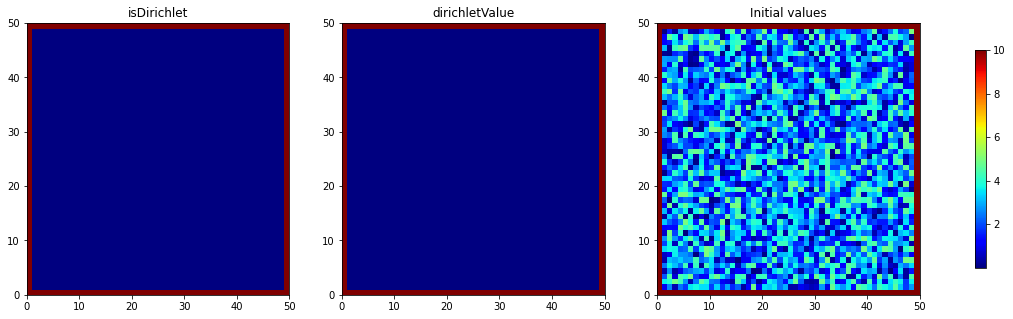

In [2]:
import matplotlib.pyplot as plt

# set seed for repeatability
np.random.seed(3)

# create a 50x50 grid
grid = LaplaceSolverGrid()
grid.setup(50,50)

# set boundary nodes to constant value
for i in range(50):
    grid.setDirichletNode(i, 0, 10.)
    grid.setDirichletNode(i, 49, 10.)
    grid.setDirichletNode(0, i, 10.)
    grid.setDirichletNode(49, i, 10.)

grid.initRandom(0., 5.)

grid.plots()

Now we are ready to implement the Jacboi method itself. The function takes a `LaplaceSolverGrid` object as its first argument, a convergence condition `atol` (which will halt iteration when the maximum change in any node is less than the specified value), as well as min and max numbers of iterations. SInce the Jacobi method reqires two copies of the grid, the function makes a copy

The results will be available in the grid object, but the function also returns the number of iterations taken, as well as the resulting maximum difference, so we can study its performance.

In [3]:
import copy

def runJacobi(grid0, atol, nmin, nmax):
    """Implement Jacobi relaxation"""
    
    # make a copy of the grid
    grid1 = copy.deepcopy(grid0)

    # this loop just keeps track of the iteration number
    for k in range(nmax) :

        # double loop to scan over the grid nodes
        for i in range(grid0.v.shape[0]):
            for j in range(grid0.v.shape[1]):

                # do not update Dirichlet nodes
                if grid0.isDirichlet[i,j]:
                    grid1.v[i,j] = grid.dirichletValue[i,j]
                    
                # but set new version (grid1) of remaining nodes to the FDE value
                else:
                    grid1.v[i,j] = grid0.fde(i,j)
                
        # test for convergence and quit
        if k>nmin and np.allclose(grid0.v, grid1.v, atol=atol):
            grid0.v = np.copy(grid1.v)
            break
        
        # update "old" version (v0) of the grid
        # note the use of np.copy() - using = would make grid.v0 a reference to grid.v1
        grid0.v = np.copy(grid1.v)
        
    return k, np.max(np.abs(grid1.v-grid0.v))

We can test this using the grid we have already created.  In the cell below, we use the `nmin`, `nmax` arguments to fix the number of iterations and look at the impact qualitatively using the `plot()` function.

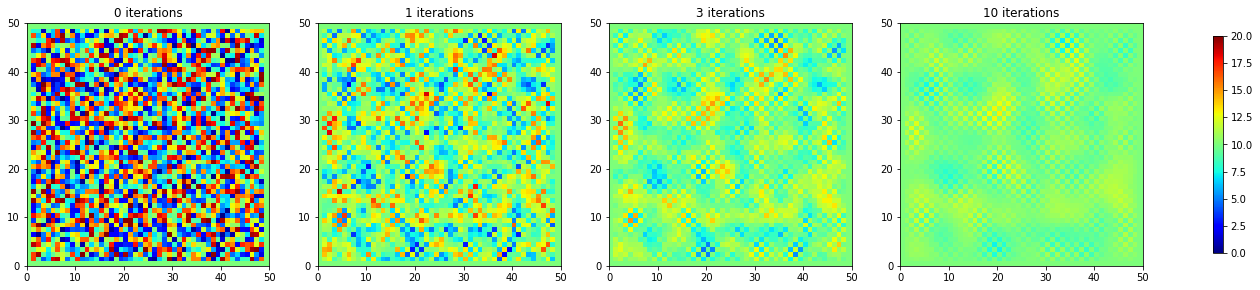

In [4]:
grid.initRandom(0, 20.)

fig, axes = plt.subplots(1, 4, figsize=(25, 5))

im = axes[0].pcolor(grid.v, vmin=0, vmax=20, cmap='jet')
axes[0].set_title("0 iterations")
axes[0].set_aspect('equal')

runJacobi(grid, 1e-12, 1, 1)
axes[1].pcolor(grid.v, vmin=0, vmax=20, cmap='jet')
axes[1].set_title("1 iterations")
axes[1].set_aspect('equal')

runJacobi(grid, 1e-12, 2, 2)
axes[2].pcolor(grid.v, vmin=0, vmax=20, cmap='jet')
axes[2].set_title("3 iterations")
axes[2].set_aspect('equal')

runJacobi(grid, 1e-12, 7, 7)
axes[3].pcolor(grid.v, vmin=0, vmax=20, cmap='jet')
axes[3].set_title("10 iterations")
axes[3].set_aspect('equal')

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

Hopefully it's clear why relaxation methods are sometimes referred to as 'smoothing' methods. The process of averaging over neighbouring nodes smooths the initially random grid. In this case, since we set Dirichlet nodes at the boundary of the grid, with constant value, the value of all nodes trend towards this value.

Now we can study the convergence time and error more systematically. Here we will iterate over a range of different tolerance requirements, and study the number of iterations taken to converge.  We can also calculate the maximum node error with respect to the known solution.

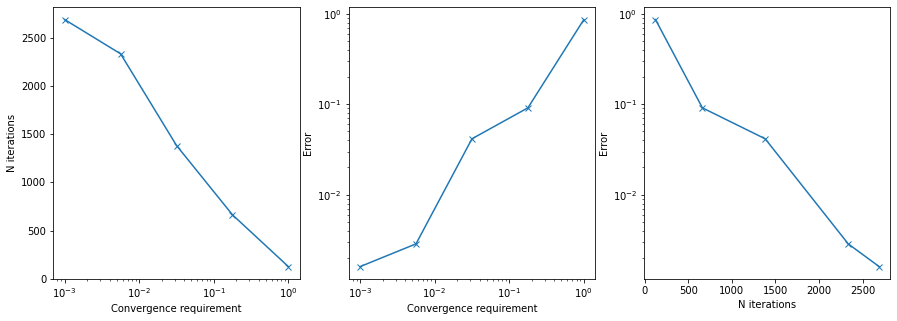

In [5]:
# define a range of tolerances to scan
tols_1 = np.logspace(0, -3, 5)

# arrays of N iterations, and max error, for plotting
ks_1 = []
errs_1 = []

# loop over a range of tolerances
for tol in tols_1:
    grid.initRandom(0, 20.)
    k, d = runJacobi(grid, tol, 1, 10000)
    
    # store number of iterations
    ks_1.append(k)
    
    # store max difference wrt known solution
    egrid = grid.v - 10.*np.ones(grid.v.shape)
    errs_1.append(np.max(np.abs(egrid)))

# define plots in a function, for re-use later
def quantPlots(tols, ks, errs):
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # plot tolerance vs N iterations
    axes[0].plot(tols, ks, marker='x')
    axes[0].set_xscale('log')
    axes[0].set_xlabel("Convergence requirement")
    axes[0].set_ylabel("N iterations")

    # plot tolerance vs error
    axes[1].plot(tols, errs, marker='x')
    axes[1].set_yscale('log')
    axes[1].set_xscale('log')
    axes[1].set_xlabel('Convergence requirement')
    axes[1].set_ylabel('Error')

    # plot N iterations vs error
    axes[2].plot(ks, errs, marker='x')
    axes[2].set_yscale('log')
    axes[2].set_xlabel('N iterations')
    axes[2].set_ylabel('Error')

    plt.show()

quantPlots(tols_1, ks_1, errs_1)

# 3. Gauss-Seidel Iteration

For Gauss-Seidel iteration, we only need one copy of the grid, and we update each node in place.  This simplifies the code in the loop over nodes.  However, the convergence test becomes a little bit more complicated.  Here we calculate how much each node changes by, when updating it, and then keep track of the maximum change (over all nodes) in one iteration.

In [6]:
def runGaussSeidel(grid, atol, nmin, nmax):
    """Implement Gauss-Seidel relaxation"""
    
    # this loop just keeps track of the iteration number
    for k in range(nmax) :

        dmax = 0.
        
        # double loop to scan over the grid
        for i in range(grid.v.shape[0]):
            for j in range(grid.v.shape[1]):

                # do not update Dirichlet nodes
                if grid.isDirichlet[i,j]:
                    grid.v[i,j] = grid.dirichletValue[i,j]
                    
                # but set other nodes to the FDE value
                # as well as assigning the node it's new value, we keep track of the amount it changed by
                # the maximum change (among all nodes) is used in the convergence test 
                else:
                    old = grid.v[i,j]
                    new = grid.fde(i,j)
                    d = new-old
                    if abs(d)>dmax:
                        dmax=abs(d)
                    grid.v[i,j] = new

        # test for convergence
        if k>nmin and dmax<atol:
            return k, dmax

    return k, dmax


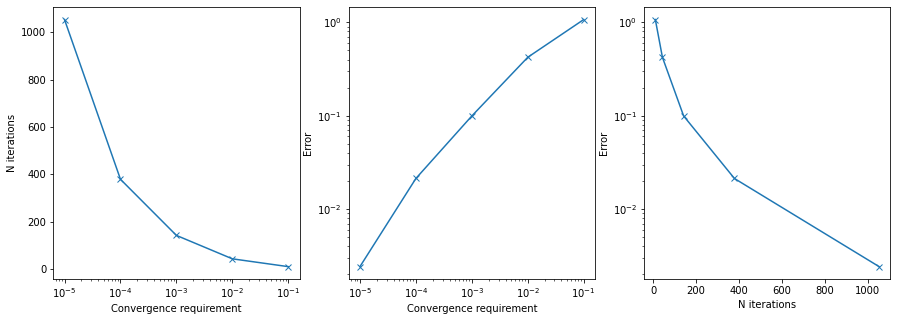

In [7]:
tols_2 = np.logspace(-1, -5, 5)
ks_2 = []
errs_2 = []

# loop over a range of tolerances
for tol in tols_2:
    grid.initRandom(0, 20.)
    k, d = runGaussSeidel(grid, tol, 1, 10000)
    
    # store number of iterations
    ks_2.append(k)
    
    # store max difference wrt known solution
    egrid = grid.v - 10.*np.ones(grid.v.shape)
    errs_2.append(np.max(np.abs(egrid)))

quantPlots(tols_2, ks_2, errs_2)

# 4. Successive Over Relaxation

Finally, we can implement the SOR method.  This is identical to Gauss-Seidel, but now we over-correct each node by a factor $\omega$.

In [8]:
def runSOR(grid, omega, atol, nmin, nmax):
    """Implement successive-over-relaxation"""
    
    # this loop just keeps track of the iteration number
    for k in range(nmax) :

        dmax = 0.
        
        # double loop to scan over the grid
        for i in range(grid.v.shape[0]):
            for j in range(grid.v.shape[1]):

                # do not update Dirichlet nodes
                if grid.isDirichlet[i,j]:
                    grid.v[i,j] = grid.dirichletValue[i,j]
                    
                # but set new version (v1) of remaining nodes to the FDE value
                else:
                    old = grid.v[i,j]
                    new = grid.fde(i,j)
                    d = new-old
                    if abs(d) > dmax:
                        dmax=abs(d)
                    grid.v[i,j] = old+omega*d

        # test for convergence
        if k>nmin and dmax<atol:
            return k, dmax

    return k, dmax

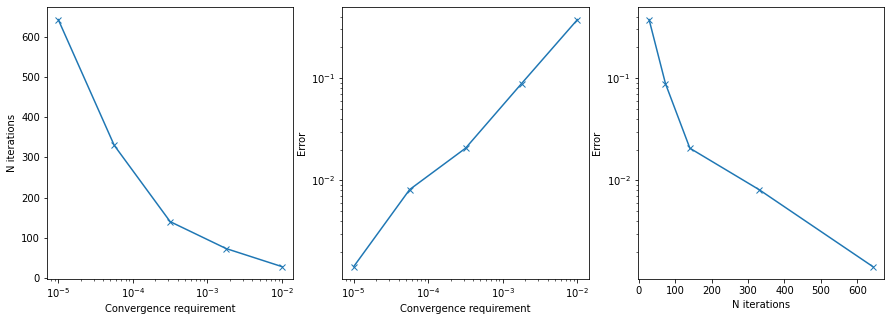

In [9]:
tols_3 = np.logspace(-2, -5, 5)
ks_3 = []
errs_3 = []

# loop over a range of tolerances
for tol in tols_3:
    grid.initRandom(0, 20.)
    k, d = runSOR(grid, 1.4, tol, 1, 10000)
    
    # store number of iterations
    ks_3.append(k)
    
    # store max difference wrt known solution
    egrid = grid.v - 10.*np.ones(grid.v.shape)
    errs_3.append(np.max(np.abs(egrid)))

quantPlots(tols_3, ks_3, errs_3)

Finally, we can compare the convergence rate of each method.  Here we plot the error with respect to the known solution, against the number of iterations required to reach convergence.  This circumvents any dependence on subtle differences between the convergence criteria for each method.

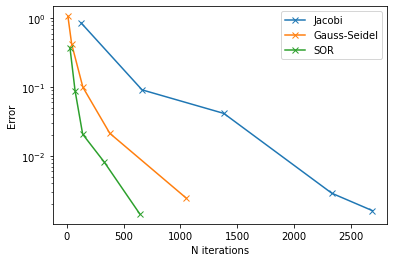

In [10]:
plt.plot(ks_1, errs_1, marker='x', label='Jacobi')
plt.plot(ks_2, errs_2, marker='x', label='Gauss-Seidel')
plt.plot(ks_3, errs_3, marker='x', label='SOR')
plt.yscale('log')
plt.xlabel('N iterations')
plt.ylabel('Error')
plt.legend()
plt.show()

# 5. The Parallel Plate Capacitor

Now we consider a practical example - calculating the potential and electric field within and around a parallel plate capacitor comprising a pair of plates of length a, separation d.

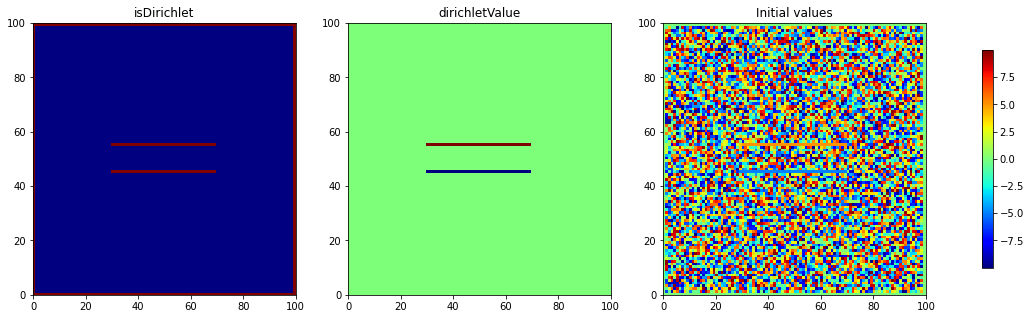

In [11]:
import math

# some parameters
n = 100 # grid size
a = 40  # capacitor plate length
d = 10  # capacitor plate separation
v = 5   # capacitor plate voltage

# setup the grid
grid = LaplaceSolverGrid()
grid.setup(n,n)

# set the edges of the grid to zero
for i in range(n):
    grid.setDirichletNode(i, 0, 0.)
    grid.setDirichletNode(i, n-1, 0.)
    grid.setDirichletNode(0, i, 0.)
    grid.setDirichletNode(n-1, i, 0.)

# now set capacitor plate boundary conditions
ymid = math.floor(n/2)
ytop = ymid+math.floor(d/2)
ybot = ymid-math.floor(d/2)
xleft = ymid-math.floor(a/2)
for i in range(a):
    grid.setDirichletNode(ytop, xleft+i, v)
    grid.setDirichletNode(ybot, xleft+i, -1*v)

# initialize grid
grid.initRandom(-10., 10.)
grid.plots()

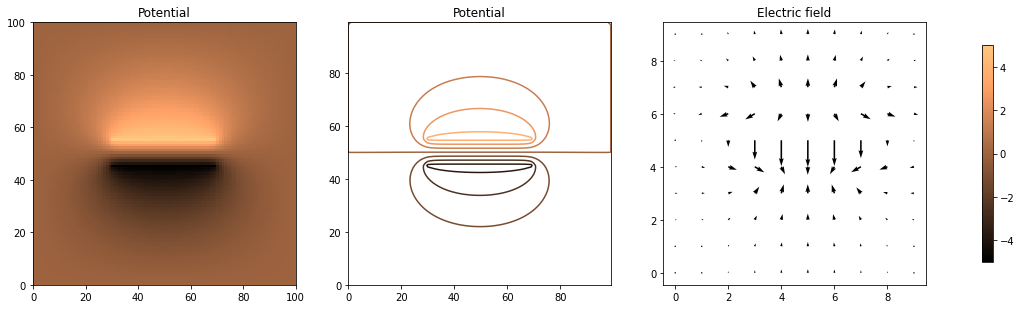

In [12]:
# run the SOR relaxation
k, d = runSOR(grid, 1.1, 1e-3, 10, 10000)


import matplotlib
#cm = matplotlib.cm.copper

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# plot the potential
im = axes[0].pcolor(grid.v, cmap='copper')
axes[0].set_title('Potential')
axes[0].set_aspect('equal')

# plot potential contours
axes[1].contour(grid.v, cmap='copper')
axes[1].set_aspect('equal', 'box')
axes[1].set_title('Potential')
axes[1].set_aspect('equal')

# calculate and plot electric field
dy, dx = np.gradient(grid.v[::10,::10])
axes[2].quiver(-dx, -dy, scale=40)
axes[2].set_title('Electric field')
axes[2].set_aspect('equal')

plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8)
plt.show()

The field is clearly uniform between the plates, as expected. We can also see the non-zero field outside the plates, due to the finite size of the plates.  (Recall that, due to Gauss' law, the field is zero outside the plates in the infinite plate approximation).